# Exploring Home Advantage in European Football

As with most sports, football games often do not take place in a neutral venue with one team playing in its home stadium. The home team gets to play in familiar surroundings, enjoys the support of the home crowd and does not have to travel far. Meanwhile the away team might has to contend with the weather ("[can they do it on a cold rainy night in Stoke?](https://www.bbc.com/sport/football/35672813)"), different time zones and possible [referee bias](https://www.tandfonline.com/doi/full/10.1080/02640410601038576).

But, just how important is home advantage and how much of a role does it play? In order to probe this question I used data from the leagues in eleven European countries, covering eight seasons (2012-2016). The dataset is publically available here - https://www.kaggle.com/hugomathien/soccer.

First I took a look at the distibution of results across the whole dataset. Remember that in football a game can end in a home win, away win or draw.


In [1]:
# Import data and relevant libraries

import sqlite3
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import descartes as dscrts
import io

from matplotlib import pyplot as plt
from matplotlib.colors import rgb2hex
from bokeh.io import save, show, output_file, output_notebook, reset_output, export_png
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh import palettes
from bokeh.models.callbacks import CustomJS
from bokeh.models.widgets import Div
from bokeh.layouts import widgetbox, row, column
from bokeh.models import (
    GeoJSONDataSource, ColumnDataSource, ColorBar, Slider, Spacer,
    HoverTool, TapTool, Panel, Tabs, Legend, Toggle, LegendItem,
)

# Create your connection.
cnx = sqlite3.connect('../input/soccer/database.sqlite')

# Import tables from football database

df_match = pd.read_sql_query("SELECT * FROM Match", cnx)
df_league = pd.read_sql_query("SELECT * FROM League;", cnx)
df_team = pd.read_sql_query("SELECT * FROM Team;", cnx)

# Add countries to League dataset

countries = ['Belgium', 'United Kingdom', 'France', 'Germany', 'Italy', 'Netherlands', 'Poland', 'Portugal', 'Scotland', 'Spain', 'Switzerland']

df_league['country'] = pd.Series(countries)

# Import Europe shape file for map

df_europe = gpd.read_file('../input/eushapefile/NUTS_RG_20M_2016_3035_LEVL_0.shp')
df_europe = df_europe.to_crs({'init':'epsg:2154'})

# Import country codes csv for Europe shape file

df_countrycodes = pd.read_csv('../input/eushapefile/Ccodes.csv')

# Create a result variable

def f(row):
    if row['home_team_goal'] == row['away_team_goal']:
        val = 0
    elif row['home_team_goal'] > row['away_team_goal']:
        val = 1
    elif row['home_team_goal'] < row['away_team_goal']:
        val = -1
    else:
        value = 99
    return val

df_match['result'] = df_match.apply(f, axis=1)


## Create a map with home win percentages for all the leagues in our database

df_map = df_match.loc[:, ['league_id','season','result']]

# Calculate number of home wins

df_map['result'] = ["Hw" if x ==1 else "Oth" for x in df_map['result']]

# Create crosstab of wome wins per league and season

df_map = pd.crosstab([df_map['league_id'],df_map['season']], df_map['result'])

df_map.reset_index(inplace=True)

# Calculate home win percentage

df_map['Hwin_perc'] = (df_map['Hw'] *100)/(df_map['Oth'] + df_map['Hw'])

# Create a dictionary with legue ids and country names from league dataframe

lgname_dict = pd.Series(df_league.name.values,index=df_league.country_id).to_dict()

# Add league names to our Europe shapefile dataframe

# df_map['league_name'] = df_map['league_id'].map(lgname_dict)

## Attach league win data to Europe shapefile

# Remove unneeded columns from Europe shapefile

df_europe = df_europe.drop(df_europe.columns[[0, 1, 2, 3]], axis=1)

# Merge with country codes dataframe

df_europe = df_europe.merge(df_countrycodes, left_on='FID', right_on='Code')

# Create a dictionary with legue ids and country names from league dataframe

lg_dict = pd.Series(df_league.name.values,index=df_league.country).to_dict()

# Add league names to our Europe shapefile dataframe

df_europe['league'] = df_europe['Name'].map(lg_dict)

# Pivot our league home win percentage dataframe so it can be merged with shapefile

df_map = df_map.pivot(index='league_id', columns='season', values='Hwin_perc')

# Create inverted mapping to add league ids to shapefile

inv_map = {v: k for k, v in lgname_dict.items()}

# Add league id column to shapefile

df_europe['league_id'] = df_europe['league'].map(inv_map)

# Merge home win percentage on league id column

df_europe = pd.merge(df_europe, df_map, on='league_id', how='left')

# Drop unneeded columns used for merging

df_europe = df_europe.drop(df_europe.columns[[0, 3, 4, 6]], axis=1)

# Melt data into long format so each season has a seperate row

df_europe = pd.melt(df_europe,id_vars=['Name','league','geometry'],var_name='season', value_name='hwin_perc')

#Replace NaN values to string 'No data'.
# df_europe.hwin_perc.fillna('No data', inplace = True)

# Add in years in order to have numerical season values
seasons = df_europe.season.unique().tolist()
years = range(2009,2017)
year_dict = dict(zip(seasons, years))
df_europe['year'] = df_europe['season'].map(year_dict)

# Rename United Kingdom to England
df_europe['Name'] = df_europe['Name'].replace({'United Kingdom': 'England'})

# Remove distant territories from France and Portugal to make a concise map of Europe

def remove_multi(cloc, cname):
    mp = df_europe.geometry.loc[cloc]
    mp_updated = mp[0:1]
    df_europe['geometry'] = np.where((df_europe.Name == cname),mp_updated,df_europe.geometry)

remove_multi(3, "France")
remove_multi(19, "Portugal")
remove_multi(0, "Spain")

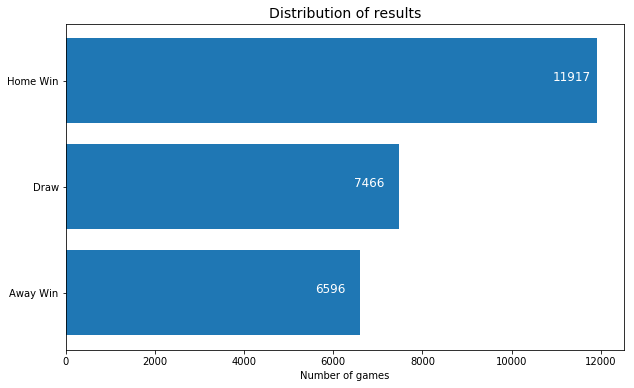

In [2]:
# Set figure size

plt.rcParams["figure.figsize"] = (10,6)

# Create a horizontal bar graph to visualize distribution of results

fig, ax = plt.subplots()

# Create labels

lbls1 = ['Away Win', 'Draw', 'Home Win']
y_pos = np.arange(len(lbls1))

# Create results count

rslts = df_match['result'].value_counts().sort_values(ascending=True)

# Set chart parameters

ax.barh(y_pos, rslts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(lbls1)

ax.set_xlabel('Number of games')
ax.set_title('Distribution of results', size = 14)



for i, v in enumerate(rslts):
    ax.text(v - 1000, i, str(v),  fontsize='12', color = "white")

plt.show()

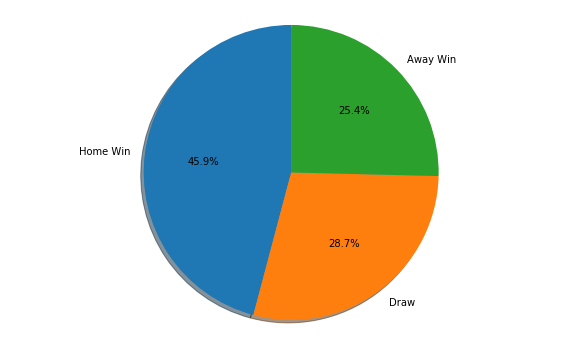

In [3]:
fig1, ax1 = plt.subplots()
ax1.pie(df_match['result'].value_counts(), labels = ["Home Win","Draw","Away Win"], startangle=90, autopct='%.1f%%', shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

We see that from our total of 25,979 about 46% are home wins, 29% are draws and the away team wins only 25% of the time. On average it is twice as likely for a home team to win as the away team for a randomly selected game.

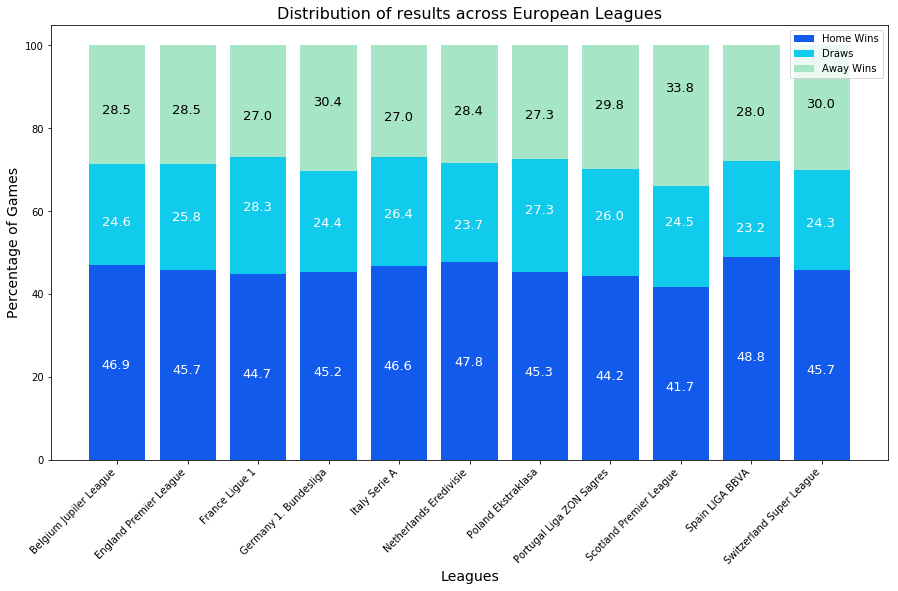

In [4]:
# Set figure size

plt.rcParams["figure.figsize"] = (15,8)

# Create a crosstab of leagues and match results

df_lgrslts = pd.crosstab(df_match['league_id'], df_match['result'])

# Transform the absolute values into normalized percentage values

totals = [i+j+k for i,j,k in zip(df_lgrslts.iloc[:,0], df_lgrslts.iloc[:,1], df_lgrslts.iloc[:,2])]    
Hloss = [i / j * 100 for i,j in zip(df_lgrslts.iloc[:,0], totals)]
Draw = [i / j * 100 for i,j in zip(df_lgrslts.iloc[:,1], totals)]
Hwin = [i / j * 100 for i,j in zip(df_lgrslts.iloc[:,2], totals)]

# Setting up variables for stacked bar chart

df_lgrslts.index = df_lgrslts.index.map(str)    
    
leagues = df_lgrslts.index
names = df_league['name']
r = [0,1,2,3,4,5,6,7,8,9,10]

# Plot bars (one on top of another)

plt.bar(r, Hwin, width=0.8, label='Home Wins', color='#115AEC')
plt.bar(r, Draw,  bottom=Hwin, width=0.8, label='Draws', color='#11CBEC')
plt.bar(r, Hloss, bottom=[i+j for i,j in zip(Hwin, Draw)], width=0.8, label='Away Wins', color='#A6E5C5')

# Set other graph parameters

plt.xticks(r, names, rotation = 45, ha='right')
plt.ylabel("Percentage of Games", size = '14')
plt.xlabel("Leagues", size = '14')
plt.legend(loc="upper right")
plt.title("Distribution of results across European Leagues", size = '16')

# Plot percent values on bars

for a,b in zip(r, Hwin):
    plt.text(a - 0.22, b - 25, str(round(b, 1)), color = 'white', size = '13')
    
for a,b in zip(r, Hloss):
    plt.text(a - 0.22, b + 55, str(round(b, 1)), color = 'black', size = '13')
    
for a,b in zip(r, Draw):
    plt.text(a - 0.22, b + 32, str(round(b, 1)), color = 'white', size = '13')

# Show plot

plt.show()

We see that most of the major leagues exhibit the same general trends when it comes to home team advantage. There are some slight variations with home teams in Spain being particularly formidable whilst away teams in Scotland enjoy the most wins, but we can't see any significant differences.

In [5]:
# Create bins to color each country
bins = range(32,58,2)
# create stylish labels
bin_labels = [f'≤{bins[1]}%'] + [f'{bins[i]}-{bins[i+1]}%' for i in range(1,len(bins)-2)] + [f'>{bins[-2]}%']
# assign each row to a bin
df_europe['bin'] = pd.cut(
    df_europe['hwin_perc'], bins=bins, right=True, include_lowest=True, precision=0, labels=bin_labels,
).astype(str)

# Add a 'No data' bin for countries without data
df_europe.loc[df_europe['hwin_perc'].isna(), 'bin'] = 'No data'
df_europe.hwin_perc.fillna('No data', inplace = True)

# Define a color palette
palette = palettes.Blues256[::20]
palette = palette[::-1]

# Assign home win percentage to a color
def val_to_color(value, nan_color='#d9d9d9'):
    if isinstance(value, str): return nan_color
    for i in range(1,len(bins)):
        if value <= bins[i]:
            return palette[i-1]

df_europe['color'] = df_europe['hwin_perc'].apply(val_to_color)

# Assign x coordinates
def bin_to_cbar_x(value):
    if value == 'No data': return -2
    for i,b in enumerate(bin_labels):
        if value == b:
            return 5*(i)

df_europe['cbar_x'] = df_europe['bin'].apply(bin_to_cbar_x)
# Assign width
df_europe['cbar_w'] = df_europe['hwin_perc'].apply(lambda x: 2 if x == 'No data' else 2.7)

# Create color palette for the graph
countries = sorted(df_europe[df_europe["bin"] != "No data"]["Name"].unique())
n_country = len(countries)
# print("%d countries to plot" % n_country)
cmap = plt.get_cmap('gist_ncar', n_country)
country_palette = [rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

In [6]:
# define the Output file
reset_output()
output_notebook()
#output_file("hwin_trends.html", title="Home Win Percentage across seasons", mode="inline")

# Input sources
df_europe.sort_values(by=["Name","year"], inplace=True)
# source that will contain all necessary data for the map
geosource = GeoJSONDataSource(geojson=df_europe.to_json())
# source that contains the data that is actually shown on the map (for a given year)
displayed_src = GeoJSONDataSource(geojson=df_europe[df_europe['year'].isin(['No data', 2009])].to_json())
# source that will be used for the graph (we don't need the countries shapes for this)
country_source = ColumnDataSource(df_europe[df_europe['Name'] == "France"].drop(columns=["geometry"]))

# Define the Tools

# slider to select the year
slider = Slider(title='Year',start=2009, end=2016, step=1, value=2009)

# hover tool for the map
map_hover = HoverTool(tooltips=[
    ('League','@league'),
    ('Home Win Percentage (%)', '@hwin_perc')
])

# hover tool for the graph
graph_hover = HoverTool(tooltips=[
    ('League','@league'),
    ('Home Win Percentage (%)', '@hwin_perc'),
    ('Year', '@year')
])

# button for the animation
anim_button = Toggle(label="▶ Play", button_type="success", width=50, active=False)

#################


# create map figure
p = figure(
    title = 'Home win percentage in top European leagues',
    plot_height=550 , plot_width=800,
    toolbar_location="right", tools="tap,pan,wheel_zoom,box_zoom,save,reset", toolbar_sticky=False,
    active_scroll="wheel_zoom",
)
p.title.text_font_size = '16pt'
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.axis.visible = False

# Add hover tool
p.add_tools(map_hover)

# Add patches (countries) to the figure
patches = p.patches(
    'xs','ys', source=displayed_src,
    fill_color='color',
    line_color='black', line_width=0.25, fill_alpha=1,
    hover_fill_color='color',
)
# outline when we hover over a country
patches.hover_glyph.line_color = '#3bdd9d'
patches.hover_glyph.line_width = 3
patches.nonselection_glyph = None


# create the interactive colorbar
p_bar = figure(
    title=None, plot_height=80 , plot_width=750,
    tools="tap", toolbar_location=None
)
p_bar.xgrid.grid_line_color = None
p_bar.ygrid.grid_line_color = None
p_bar.outline_line_color = None
p_bar.yaxis.visible = False

# set the title and ticks of the colorbar
p_bar.xaxis.axis_label = "% Home Wins"
p_bar.xaxis.ticker = sorted(df_europe['cbar_x'].unique())
p_bar.xaxis.major_label_overrides = dict([(i[0],i[1]) for i in df_europe.groupby(['cbar_x','bin']).describe().index])
p_bar.xaxis.axis_label_text_font_size = "10pt"
p_bar.xaxis.major_label_text_font_size = "8pt"


# activate the hover but hide tooltips
hover_bar = HoverTool(tooltips=None)
p_bar.add_tools(hover_bar)

# plot the rectangles for the colorbar
cbar = p_bar.rect(x='cbar_x', y=0, width='cbar_w', height=1,
    color='color', source=displayed_src,
    hover_line_color='#3bdd9d', hover_fill_color='color')

# outline when we hover over the colorbar legend
cbar.hover_glyph.line_width = 4
cbar.nonselection_glyph = None

#################

# create the graph figure
p_country = figure(
    title="Home win rate in European leagues", plot_height=500 , plot_width=800,
    tools="pan,wheel_zoom,save", active_scroll="wheel_zoom", toolbar_location="right",
)
p_country.title.text_font_size = '14pt'
p_country.xaxis.axis_label = "Season"
p_country.yaxis.axis_label = "Home Win Percentage (%)"
p_country.axis.major_label_text_font_size = "12pt"
p_country.axis.axis_label_text_font_size = "14pt"

# plot data on the figure
line_plots = {}
legend_items = {}
for i, country in enumerate(countries):
    # get subset of data corresponding to a country
    country_source = ColumnDataSource(df_europe[df_europe['Name'] == country].drop(columns=["geometry"]))
    # plot
    line = p_country.line("year", "hwin_perc", source=country_source,
                      color=country_palette[i], line_width=2)
    circle = p_country.circle("year", "hwin_perc", source=country_source,
                          line_color="darkgrey", fill_color=country_palette[i], size=8)
    # used later in the interactive callbacks
    line_plots[country] = [line, circle]
    legend_items[country] = LegendItem(label=country, renderers=[line, circle])
    # # only display France at first
    # if country != "France":
    #     line.visible = False
    #     circle.visible = False

default_legend = [
    ("Belgium", line_plots["Belgium"]),
    ("England", line_plots["England"]),              
    ("France", line_plots["France"]),
    ("Germany", line_plots["Germany"]),
    ("Italy", line_plots["Italy"]),
    ("Netherlands", line_plots["Netherlands"]),
    ("Poland", line_plots["Poland"]),
    ("Portugal", line_plots["Portugal"]),
    ("Spain", line_plots["Spain"]),
    ("Switzerland", line_plots["Switzerland"])    
]
legend = Legend(items=default_legend, location="top_center")
legend.click_policy = "hide"
p_country.add_layout(legend, 'right')

# Add hover tool
p_country.add_tools(graph_hover)

#######################


# JS callbacks

# Update the map on slider change
slider_callback = CustomJS(args=dict(slider=slider, source=geosource, displayed_src=displayed_src), code="""
    var year = slider.value;
    var show = [year, 'No data'];
    var data = {};
    columns = Object.keys(source.data);
    columns.forEach(function(key) {
        data[key] = [];
    });
    for (var i = 0; i < source.get_length(); i++){
        if (show.includes(source.data['year'][i])){
            columns.forEach(function(key) {
                data[key].push(source.data[key][i])
            });
        }
    }
    displayed_src.data = data;
    displayed_src.change.emit();
""")
slider.js_on_change('value', slider_callback)


# Add callback on country click
plot_callback = CustomJS(args=dict(
    csource=country_source, source=geosource, displayed_src=displayed_src, line_plots=line_plots, legend=legend, legend_items=legend_items), code="""
    // only continue if a country was selected
    var ixs = displayed_src.selected.indices;
    if (ixs.length == 0) { return; }
    
    // init
    var data = {};
    var items = [];
    countries = [];
    columns = Object.keys(source.data);
    columns.forEach(function(key) {
        data[key] = [];
    });
    
    // hide all plots
    for (var country in line_plots) {
        var line = line_plots[country][0];
        var circle = line_plots[country][1];
        line.visible = false;
        circle.visible = false;
    }
    
    // loop over the selected countries
    ixs.forEach(function(ix) {
        // identify corresponding country
        country = displayed_src.data["Country"][ix];
        countries.push(country);
    });
    // sort them in order
    countries.sort()
    // display the corresponding glyphs and legend
    countries.forEach(function(country) {
        line = line_plots[country][0];
        circle = line_plots[country][1];
        line.visible = true;
        circle.visible = true;
        items.push(legend_items[country]);
        
        for (var i = 0; i < source.get_length(); i++){
            if (source.data['Country'][i] == country) {
                columns.forEach(function(key) {
                    data[key].push(source.data[key][i])
                });
            }
        }
    });
    legend.items = items;
    csource.data = data;
    csource.change.emit();
""")
displayed_src.selected.js_on_change('indices', plot_callback)

# add animation
update_interval = 500 # in ms
anim_callback = CustomJS(args=dict(slider=slider, update_interval=update_interval), code="""
    var button = cb_obj;
    if (button.active == true){
        button.label = "◼ Stop";
        button.button_type = "danger";
        mytimer = setInterval(update_year, update_interval);           
    } else {
        button.label = "▶ Play";
        button.button_type = "success";
        clearInterval(mytimer);
    }

    function update_year() {
        year = slider.value;
        if (year < 2016) {
            slider.value += 1;
        } else {
            slider.value = 2009;
        }
    }
""")
anim_button.callback = anim_callback



Loading BokehJS ...

In [7]:
# arrange display with tabs
tab_map = Panel(title="Map",
    child=column(
        p, # map
        p_bar, # colorbar
        row(widgetbox(anim_button), Spacer(width=10), widgetbox(slider)) # animation button and slider
    ))
tab_chart = Panel(title="Chart", child=column(p_country))
tabs = Tabs(tabs=[ tab_map, tab_chart ])

# Save the document
footer = Div(text="""
Year corresponds to season end i.e. 2009 corresponds to season 2008-2009</br >
""")
layout = column(tabs, footer)
show(layout)

I thought that perhaps I could discover some sort of geographic pattern to the home win percentage, but the map above doesn't seem to indicate one. A plausible explanation for this is that home advantage is affected by a lot of factors that vary from year to year across different leagues.

On the other hand we see that home win percentage does seem to decline over the course of the eight seasons. There are a variety of reasons for this shift. For one thing improvements in travel infrastructure have made going to away games safer, quicker and more comfortable. Tactics have also evolved, with many [managers opting for counterattaking tactics](http://backpagefootball.com/shifting-sands-football-tactics-rise-counter-attack/114638/) which are more effective away from home. The [trend of declining atmosphers in top stadiums](https://www.vice.com/en_us/article/53xwp8/squeezed-fans-silent-stadiums-the-myth-of-premier-league-atmosphere) has also made it less intimidating to play on hostile territory.

In [8]:
## Create league table rankings by season for EPL

# Isolate EPL matches

EPL = df_match[df_match['league_id'] == 1729]

## For home matches

# Create 

EPL_home = pd.pivot_table(EPL,index=['season', 'home_team_api_id', 'stage'],values = ['home_team_goal','away_team_goal'])

# Create a points variable for home games

def hpoints(row):
    if row['home_team_goal'] == row['away_team_goal']:
        val = 1
    elif row['home_team_goal'] > row['away_team_goal']:
        val = 3
    elif row['home_team_goal'] < row['away_team_goal']:
        val = 0
    else:
        value = 99
    return val

# Create a points variable for away games (scoring is reversed as away team gets 3 points)

def apoints(row):
    if row['home_team_goal'] == row['away_team_goal']:
        val = 1
    elif row['home_team_goal'] > row['away_team_goal']:
        val = 0
    elif row['home_team_goal'] < row['away_team_goal']:
        val = 3
    else:
        value = 99
    return val

# Calculate home points

EPL_home['hpoints'] = EPL_home.apply(hpoints, axis=1)

# Sum home points

EPL_home = pd.pivot_table(EPL_home,index=['season', 'home_team_api_id'],values = ['hpoints'], aggfunc=np.sum)

## For away matches

EPL_away = pd.pivot_table(EPL,index=['season', 'away_team_api_id', 'stage'],values = ['home_team_goal','away_team_goal'])

# Create a result variable

EPL_away['apoints'] = EPL_away.apply(apoints, axis=1)

# Sum away points by team

EPL_away = pd.pivot_table(EPL_away,index=['season', 'away_team_api_id'],values = ['apoints'], aggfunc=np.sum)

## Combine home and away points into one consolidated dataframe

df_EPL = pd.DataFrame(EPL_home)

# Test to make sure away points are in correct order (should be same for both columns)

df_EPL['apoints'] = EPL_away['apoints']

# Create away points column in consolidated dataframe and copy in values from away games dataframe

df_EPL['apoints'].equals(EPL_away['apoints'])

# Calculate total points

df_EPL['tpoints'] = df_EPL['hpoints'] + df_EPL['apoints']

# Sort dataframe by season and points to mimic league table standings by season

df_EPL.sort_values(by=['season','tpoints'], inplace=True, ascending = False)

# Convert index values to columns

df_EPL.reset_index(inplace=True)

# Rename column

df_EPL = df_EPL.rename(columns={'home_team_api_id': 'team_id'})

# Create a dictionary with team ids and names from team dataframe

team_dict = pd.Series(df_team.team_long_name.values,index=df_team.team_api_id).to_dict()

# Add team names to our EPL_home dataframe

df_EPL['team_name'] = df_EPL['team_id'].map(team_dict)

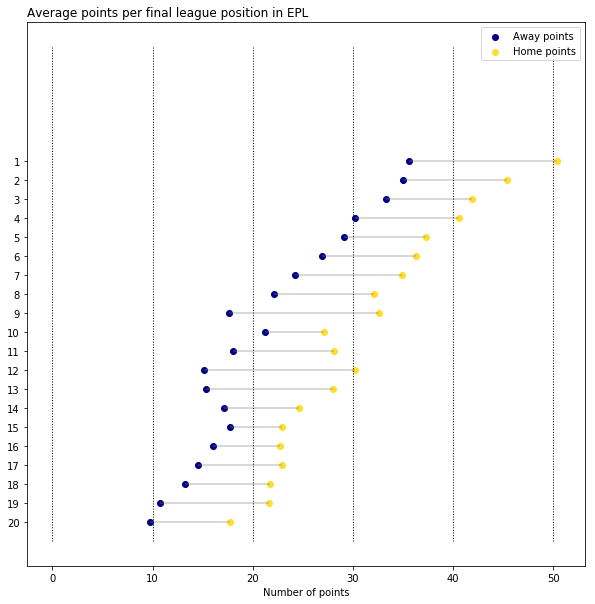

In [9]:
# Set figure size

plt.rcParams["figure.figsize"] = (10,10)

import statistics

# Initialize empty listss

position = list(range(0,20))
hpoints = []
apoints = []
tpoints = []

# Calculate average points by each position

for i in range(20):
        tpoints.append(statistics.mean(df_EPL['tpoints'][i::20]))
        hpoints.append(statistics.mean(df_EPL['hpoints'][i::20]))
        apoints.append(statistics.mean(df_EPL['apoints'][i::20]))

# Create a dataframe from our lists        
        
frame = { 'position': position, 'hpoints': hpoints, 'apoints': apoints, 'tpoints': tpoints } 

df_avg = pd.DataFrame(frame) 

## Create a dumbbell chart for average points per EPL position

df_avg = df_avg.sort_values(by='tpoints')
my_range=range(1,len(df_avg.index)+1)
plt.hlines(y=my_range, xmin=df_avg['hpoints'], xmax=df_avg['apoints'], color='grey', alpha=0.4)
plt.scatter(df_avg['apoints'], my_range, color='navy', alpha=1, label='Away points')
plt.scatter(df_avg['hpoints'], my_range, color='gold', alpha=0.8 , label='Home points')
plt.legend()

# Vertical Lines
plt.vlines(x=0, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
plt.vlines(x=10, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
plt.vlines(x=20, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
plt.vlines(x=30, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
plt.vlines(x=40, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
plt.vlines(x=50, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')

# Add title and axis names
plt.yticks(my_range, list(range(20,0,-1)))
plt.title('Average points per final league position in EPL', loc='left')
plt.xlabel('Number of points')
plt.show()

I also wondered how home advantage varies with a team's final league position. Do relegation scrappers depend on their home form to stay in the league? Is the title won by winning away at your rivals?

Plotting out the average home and away points by final league position over the 8 seasons shows that all teams, regardless of their final league position, scored more points at home than away. 

However there are some interesting patterns at play. For starters we notice that there is not a lot of difference in away points on average between the top two, but there is a significant different in home points. The team that won the league scored 51 points on average at home, indicating that the stadium of the champions would be transformed into a home fortress. The data suggests that any team aiming to win the title should ensure it wins at home and avoids defeat in top-of-the-table clashes.

We also see the importance of home points at the bottom of the table. For relegations battlers there is not a significant difference between positions and to when it comes to away points. In fact winning a couple of extra games is often the difference between safety and relagation.

Text(0, 0.5, 'Position')

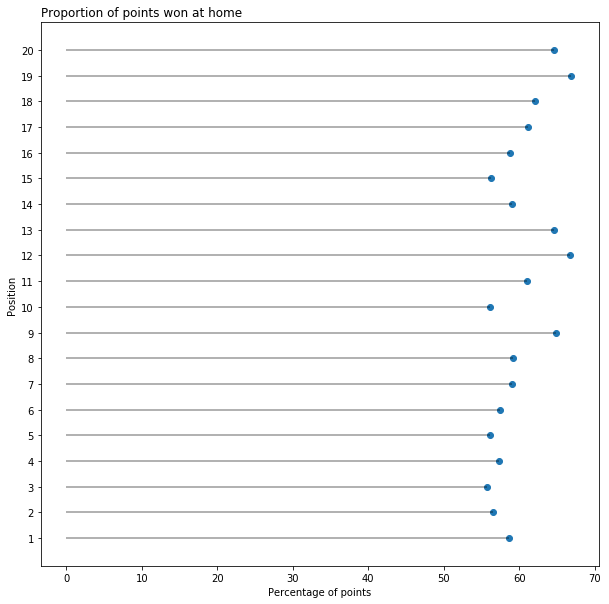

In [10]:
# Initialize empty listss

position = list(range(0,20))
hpoints = []
apoints = []
tpoints = []

# Calculate total points by each position

for i in range(20):
        tpoints.append(sum(df_EPL['tpoints'][i::20]))
        hpoints.append(sum(df_EPL['hpoints'][i::20]))
        apoints.append(sum(df_EPL['apoints'][i::20]))

# Create a dataframe from our lists        
        
frame = { 'position': position, 'hpoints': hpoints, 'apoints': apoints, 'tpoints': tpoints } 

df_sum = pd.DataFrame(frame) 

df_sum['diff'] = df_sum['hpoints'] - df_sum['apoints']
df_sum['prop'] = (df_sum['hpoints'] / df_sum['tpoints']) *100

#####

# libraries
import pandas as pd
import matplotlib.pyplot as plt
 

# Reorder it following the values:
df_sum = df_sum.sort_values(by='position', ascending = 'True')
my_range=range(1,len(df_sum.index)+1)
 
# Create a color if the group is "B"
# my_color=np.where(df_sum ['group']=='B', 'orange', 'skyblue')
# my_size=np.where(df_sum ['group']=='B', 70, 30)
 
# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.hlines(y=my_range, xmin=0, xmax=df_sum['prop'], alpha=0.4)
plt.scatter(df_sum['prop'], my_range, alpha=1)
 
# Add title and exis names
plt.yticks(my_range, df_sum['position']+1)
plt.title("Proportion of points won at home", loc='left')
plt.xlabel('Percentage of points')
plt.ylabel('Position')

### Appendix:

For anyone looking to reminisce I plotted out dumbbell charts comparing home and away points by PL season from 2008-09 to 2015-16.



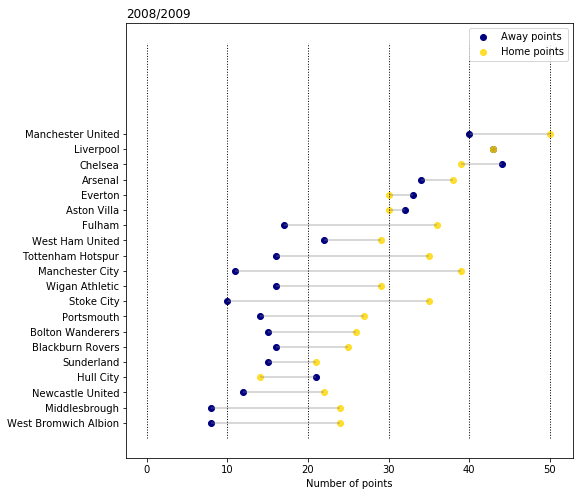

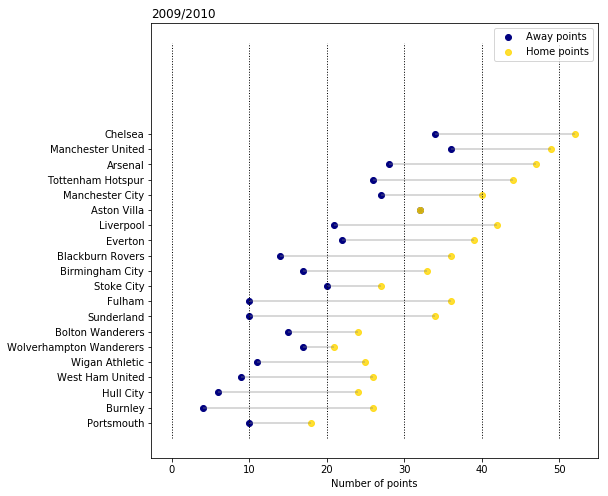

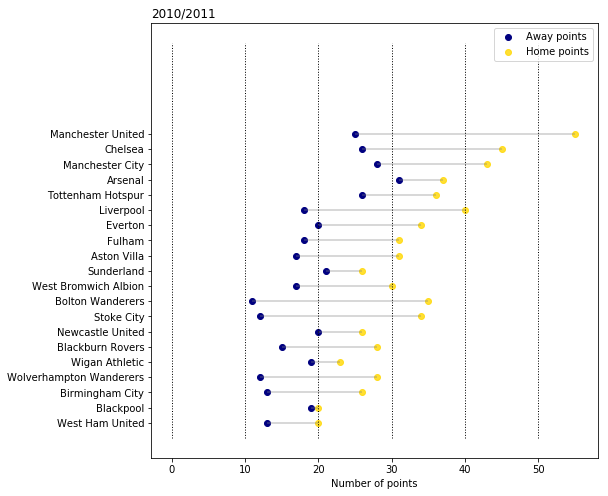

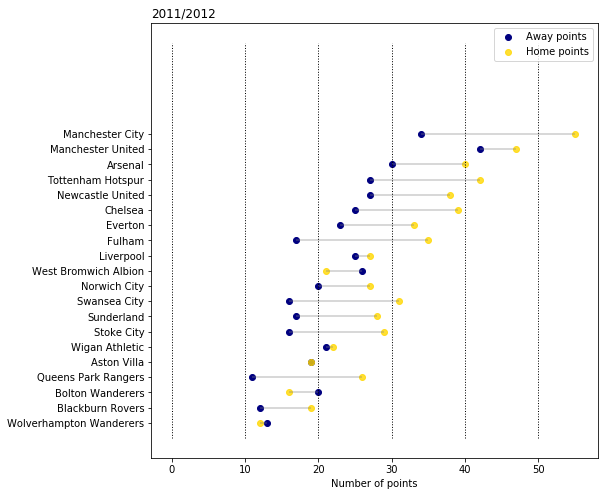

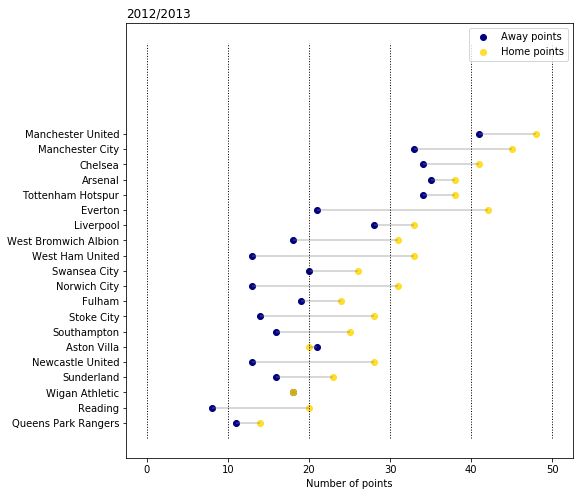

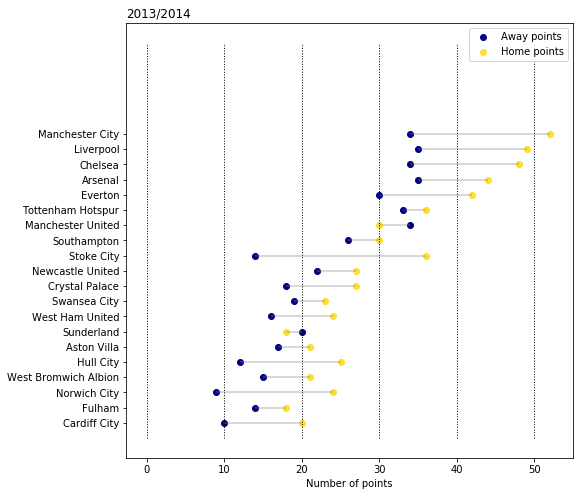

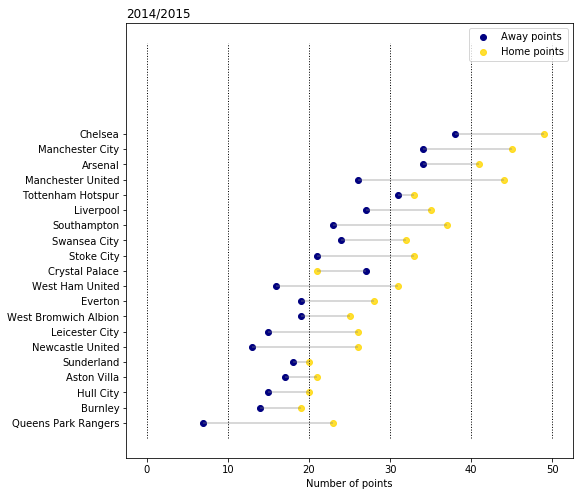

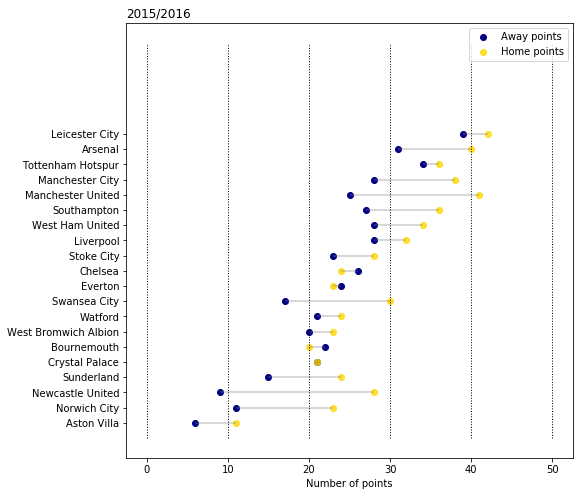

In [11]:
# Set figure size

plt.rcParams["figure.figsize"] = (8,8)

def plot_dumbell_chart(season):

    df_season = df_EPL[df_EPL['season'] == season]
    df_season = df_season.sort_values(by='tpoints')
    my_range=range(1,len(df_season.index)+1)
    plt.hlines(y=my_range, xmin=df_season['hpoints'], xmax=df_season['apoints'], color='grey', alpha=0.4)
    plt.scatter(df_season['apoints'], my_range, color='navy', alpha=1, label='Away points')
    plt.scatter(df_season['hpoints'], my_range, color='gold', alpha=0.8 , label='Home points')
    plt.legend()

# Vertical Lines
    plt.vlines(x=0, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
    plt.vlines(x=10, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
    plt.vlines(x=20, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
    plt.vlines(x=30, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
    plt.vlines(x=40, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
    plt.vlines(x=50, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')    
    
# Add title and axis names
    plt.yticks(my_range, df_season['team_name'])
    plt.title(season, loc='left')
    plt.xlabel('Number of points')
    plt.show()

season_vals = sorted(df_EPL.season.unique())

for i in season_vals:
  plot_dumbell_chart(i)